In [86]:
import igraph as ig
import numpy as np
import os
import pandas as pd
import statistics
import networkx as nx
import nx_cugraph as nxcg
import powerlaw
import random
from time import time
import matplotlib.pyplot as plt
from auxiliar_bb import noise_corrected, disparity
from auxiliar_projections_large import apply_projection

In [67]:
FILENAME = "TOY-GRAPH.graphml"
FILENAME = "binet-AMZ-Rw.graphml"

In [68]:
###### ****** Read BI GRAPH ****** ######
g = ig.read(FILENAME)
print(g.summary())
print()

user_nodes = g.vs.select(type=0)
res_nodes = g.vs.select(type=1)

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()
print("|U|=",len(user_nodes), " \t|R|=",len(res_nodes), " \t|U|+|R|=",
      len(user_nodes)+len(res_nodes), "=", g.vcount())
print()
###### ****** END ****** ######

IGRAPH U-WT 17079 32769 -- 
+ attr: freq (v), id (v), type (v), weight (e)

The graph IS bipartite
|U|= 9561  	|R|= 7518  	|U|+|R|= 17079 = 17079



In [4]:
def bipartite_cc_uu_prime(graph, u_id, u_prime_id):
    """
    Calculates the Jaccard index based clustering coefficient for a pair of vertices
    u and u' from the same set of nodes in a bipartite graph.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute.
        u_id: The ID of the first vertex.
        u_prime_id: The ID of the second vertex.

    Returns:
        The Jaccard index (cc_u_u_prime) or 0 if union of neighbors is empty.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")

    # Get neighbors of u and u'
    neighbors_u = set(graph.neighbors(u_id))
    neighbors_u_prime = set(graph.neighbors(u_prime_id))

    # Calculate intersection and union
    intersection = len(neighbors_u.intersection(neighbors_u_prime))
    union = len(neighbors_u.union(neighbors_u_prime))

    if union == 0:
        return 0.0
    return intersection / union
 
def local_bipartite_clustering_coefficient(graph, u_id, U_type_value=False):
    """
    Calculates the local clustering coefficient for a vertex u in a bipartite graph.
    The formula uses neighbors of neighbors (N(N(u))) that are of the same type as u.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute
               (e.g., True/False or 0/1 for the two partitions).
        u_id: The ID of the vertex for which to calculate the local clustering coefficient.
        U_type_value: The boolean value (True/False) that indicates the partition
                      to which node u belongs. All nodes in U should have this type.

    Returns:
        The local clustering coefficient for vertex u, or 0 if N(N(u)) is empty.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")
    if "type" not in graph.vs.attributes():
        raise ValueError("Bipartite graph must have a 'type' vertex attribute.")

    # Ensure u_id is of the specified U_type_value
    if graph.vs[u_id]["type"] != U_type_value:
        raise ValueError(f"Vertex {u_id} does not belong to the specified partition U.")

    # Get neighbors of u
    neighbors_u = graph.neighbors(u_id)
    
    # Get neighbors of neighbors of u, filtering for nodes of the same type as u
    # These are the u' nodes in N(N(u)) that are in the same partition U
    nn_u = set()
    for v_neighbor_id in neighbors_u:
        for nn_id in graph.neighbors(v_neighbor_id):
            if graph.vs[nn_id]["type"] == U_type_value and nn_id != u_id: # Exclude u itself
                nn_u.add(nn_id)

    if not nn_u:
        return 0.0

    sum_cc_uu_prime = 0.0
    for u_prime_id in nn_u:
        sum_cc_uu_prime += bipartite_cc_uu_prime(graph, u_id, u_prime_id)

    return sum_cc_uu_prime / len(nn_u)

def average_local_bipartite_clustering_coefficient(graph, U_type_value=False):
    """
    Calculates the average local clustering coefficient for a set of nodes U
    in a bipartite graph.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute.
        U_type_value: The boolean value (True/False) that indicates the partition
                      for which to calculate the average clustering coefficient.

    Returns:
        The average local clustering coefficient for the set U.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")
    if "type" not in graph.vs.attributes():
        raise ValueError("Bipartite graph must have a 'type' vertex attribute.")

    # Get all vertices in set U
    U_vertices_ids = [v.index for v in graph.vs if v["type"] == U_type_value]

    if not U_vertices_ids:
        return 0.0

    sum_cc_u = 0.0
    for u_id in U_vertices_ids:
        sum_cc_u += local_bipartite_clustering_coefficient(graph, u_id, U_type_value)

    return sum_cc_u / len(U_vertices_ids)

def compute_power_law_bipartite(gb, type_n):
    """Calcula el alpha del bipartita"""
    fit = powerlaw.Fit(gb.degree(gb.vs.select(type=type_n)), discrete=True, verbose=False)
    return fit.alpha

def compute_power_law(g):
    """Calcula el alpha del proyectado"""
    fit = powerlaw.Fit(g.degree(), discrete=True, verbose=False)
    return fit.alpha

def remove_isolated_nodes(graph, k):
        
    #print(f"Número inicial de vértices: {graph.vcount()}")
    #print(f"Componentes iniciales: {len(graph.clusters())}")

    # 1. Obtener los clústeres
    clusters = graph.clusters()

    # 2. Identificar los IDs de los vértices a eliminar
    vertices_to_delete = []
    for i, cluster_members in enumerate(clusters):
        if len(cluster_members) < k:
            vertices_to_delete.extend(cluster_members)

    # Eliminar duplicados si un vértice pudiera aparecer en múltiples listas por algún error (no debería pasar con clusters)
    # Aunque igraph maneja esto bien, es una buena práctica si la lista se construye de forma menos controlada
    vertices_to_delete = sorted(list(set(vertices_to_delete)), reverse=True) # Eliminar en orden descendente para evitar problemas de reindexación

    # 3. Eliminar los vértices
    if vertices_to_delete:
        graph.delete_vertices(vertices_to_delete)
        #print(f"Nodos eliminados: {len(vertices_to_delete)}")

    #print(f"Número final de vértices: {graph.vcount()}")
    #print(f"Componentes finales: {len(graph.clusters())}")
    return graph

In [166]:
def compute_avg_path_length(g, k):
    G = g.to_networkx()
    nxG = nxcg.from_networkx(G)
    all_nodes = list(G.nodes())
    sample_nodes = random.sample(all_nodes, k)
    total_distances = 0
    reachable_pairs = 0
    for i, src_node in enumerate(sample_nodes):
        sssp_df = nxcg.shortest_path_length(nxG, source=src_node)
        total_distances += sum(sssp_df.values())
        reachable_pairs += len(sssp_df.values())

    apl_approx = float(total_distances) / reachable_pairs
    return apl_approx

def compute_weight_distribution(pesos):
    fit = powerlaw.Fit(pesos, discrete=True, verbose=False)
    return fit.alpha


def compute_bip_metrics(gb, typen):
    """Calcula x1,x2,x3,x8,x9,γ_Ub del grafo bipartito."""
    x1 = len(gb.vs.select(type=0))
    x2 = len(gb.vs.select(type=1))
    x3 = gb.ecount()
    #x8 = average_local_bipartite_clustering_coefficient(gb, U_type_value=typen)    
    x8 = 1
    x9 = compute_avg_path_length(gb, 100)
    x11 = compute_power_law_bipartite(gb, typen)
    return dict(x1=x1, x2=x2, x3=x3, x8=x8, x9=x9, x11=x11)

def compute_proj_metrics(gu, k):
    """Calcula x4,x5,x6,x7,x10,γ_U de la proyección."""
    x4 = gu.vcount()
    x5 = gu.ecount()
    x6 = len(gu.clusters(mode='weak'))
    x7 = gu.transitivity_undirected(mode="zero")
    x10 = compute_avg_path_length(gu, k)
    x12 = compute_power_law(gu)
    #x13 = compute_weight_distribution(gu.es["weight"])
    x13 = statistics.mean(gu.es["weight"])
    return dict(x4=x4, x5=x5, x6=x6, x7=x7, x10=x10, x12=x12, x13=x13)

def evaluate_solution(bip, proj, typen):
    """Dado bip y proj metrics, arma x, f, g."""
    # unimos diccionarios
    x = {
        **bip,
        **proj
    }
    # objetivos
    f = np.array([
        abs(x["x1"] - x["x4"]) if typen==0 else abs(x["x2"] - x["x4"]),
        (2*x["x5"]) / (x["x4"]*(x["x4"]-1)) if x["x4"]>1 else np.inf,
        #x["x6"],
        1 - x["x7"],
        abs(x["x11"] - x["x12"]),
        abs(x["x9"] - x["x10"]),
        x["x13"]
    ])
    # restricciones g_i(x)<=0
    g = np.array([
        #f[1] - x["x3"]/(x["x1"]*x["x2"]) if x["x1"]*x["x2"]>0 else np.inf,
        (x["x1"]/2)-(x["x4"])  if typen==0 else (x["x2"]/2)-(x["x4"]), # mitad de los nodos
        (x["x1"]-1) - x["x5"] if typen==0 else (x["x2"]-1) - x["x5"] # Cuerda
    ])
    return dict(metrics=x, f=f, g=g, graph=proj)
    #return dict(metrics=x, f=f, graph=proj)

def is_feasible(sol):
    #return np.all(sol["g"] <= 0)
    if np.all(sol["g"] <= 0):
        return 1

def pareto_front(sols):
    front = []
    for i, si in enumerate(sols):
        if any(np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"])
               for j, sj in enumerate(sols) if i!=j):
            continue
        front.append(si)
    return front

def crowding_distance(front):
    N, k = len(front), front[0]["f"].size
    F = np.array([s["f"] for s in front])
    dist = np.zeros(N)
    for m in range(k):
        idx = np.argsort(F[:,m])
        f_min, f_max = F[idx[0],m], F[idx[-1],m]
        dist[idx[0]] = dist[idx[-1]] = np.inf
        if f_max == f_min: continue
        for i in range(1, N-1):
            dist[idx[i]] += (F[idx[i+1],m] - F[idx[i-1],m]) / (f_max - f_min)
    return dist

def pareto_rank_all(solutions):
    """
    Clasifica todas las soluciones en frentes de Pareto.
    Devuelve una lista de listas: cada sublista contiene un frente.
    """
    remaining = solutions.copy()
    fronts = []
    
    while remaining:
        current_front = []
        for i, si in enumerate(remaining):
            dominated = False
            for j, sj in enumerate(remaining):
                if i == j:
                    continue
                if np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"]):
                    dominated = True
                    break
            if not dominated:
                current_front.append(si)
        
        fronts.append(current_front)
        remaining = [s for s in remaining if all(s is not r for r in current_front)]
    
    return fronts



In [125]:
# —————————— Flujo principal ——————————
tnodes = 1

# 1) Leer el único grafo bipartito
gb = ig.Graph.Read_GraphML("binet-AMZ-Rw.graphml")
bip_metrics = compute_bip_metrics(gb, tnodes)
bip_metrics

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 1,
 'x9': 5.7033448376090305,
 'x11': 2.154744528081951}

In [167]:
# 2) Escanear carpeta de proyecciones
if tnodes == 0:
    proj_dir = "amz/top"    
else:
    proj_dir = "amz/bot" 
    
proj_files = [f for f in os.listdir(proj_dir)
              if f.endswith(".graphml") and f!="bipartito.graphml"]


# 3) Calcular soluciones
solutions = []
conta_neg = 0
to_df = []
names_df = []
k = 100
for fname in proj_files:
    gu = ig.Graph.Read_GraphML(os.path.join(proj_dir, fname))
    gu = remove_isolated_nodes(gu, k=5)
    if k < gu.vcount():
        proj_metrics = compute_proj_metrics(gu,k)
    else:
        proj_metrics = compute_proj_metrics(gu,gu.vcount())
    sol = evaluate_solution(bip_metrics, proj_metrics, tnodes)
    to_df.append(sol["f"])
    names_df.append(fname[:-8])
    sol["filename"] = fname  # <- Añadimos esta línea
    #solutions.append(sol)
    if is_feasible(sol):
        solutions.append(sol)
    
a = pd.DataFrame(to_df)
b = pd.DataFrame(names_df)
a.columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
b.columns = ["name"]
final_DF = pd.concat([a, b], axis=1)
print("Soluciones factibles:", len(solutions))

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


Soluciones factibles: 36


<AxesSubplot:>

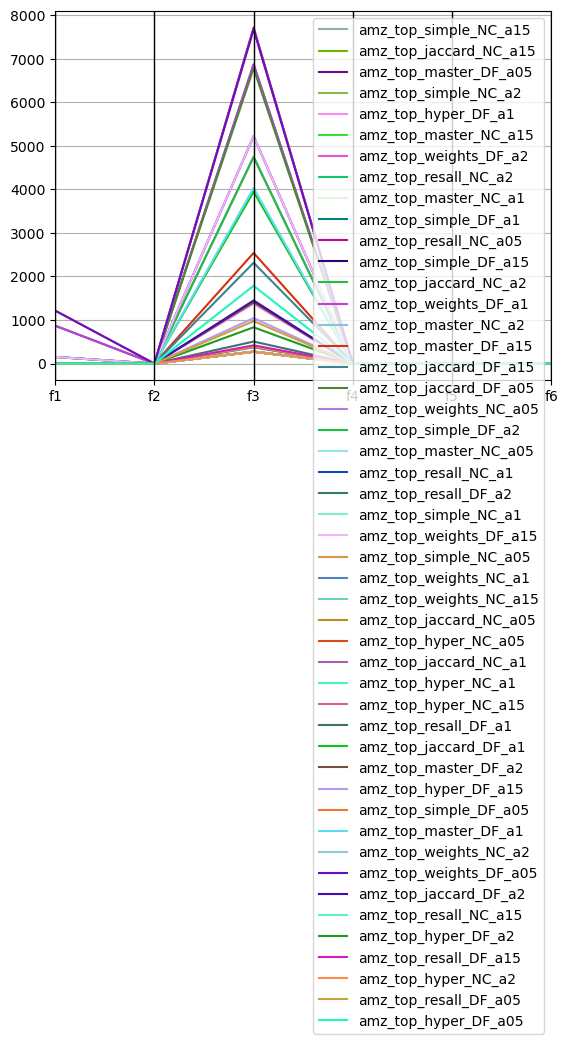

In [24]:
pd.plotting.parallel_coordinates(final_DF, 'name')  

In [168]:
all_fronts = pareto_rank_all(solutions)

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol in front:
        print(f" - {sol['filename']} — f = {sol['f']}")



Frente 1 (19 soluciones):
 - amz_bot_jaccard_NC_a2.graphml — f = [3.43000000e+02 2.69537014e-03 8.63853432e-01 3.62464181e-01
 2.68762776e+00 1.79722315e+02]
 - amz_bot_master_DF_a15.graphml — f = [1.05600000e+03 1.05032260e-03 8.94957692e-01 1.10563137e+00
 5.43567014e-01 2.89944243e+04]
 - amz_bot_jaccard_NC_a15.graphml — f = [3.43000000e+02 2.67376677e-03 8.57538939e-01 3.51985913e-01
 2.57874414e+00 1.81154910e+02]
 - amz_bot_vector_DF_a2.graphml — f = [1.26800000e+03 9.42435590e-04 9.94248200e-01 2.46772517e-01
 2.78683764e+00 1.62999348e+01]
 - amz_bot_jaccard_NC_a05.graphml — f = [3.53000000e+02 2.60673765e-03 8.36339980e-01 4.65163760e-01
 2.36460653e+00 1.86077382e+02]
 - amz_bot_jaccard_DF_a2.graphml — f = [1.84400000e+03 1.02241160e-03 6.87746129e-01 1.32489181e+00
 2.21099187e-01 3.42073595e+02]
 - amz_bot_simple_NC_a2.graphml — f = [3.35000000e+02 2.62412183e-03 8.77182160e-01 4.29603065e-01
 2.49498343e+00 1.24155303e+00]
 - amz_bot_jaccard_NC_a1.graphml — f = [3.5300000

In [169]:
cd = crowding_distance(all_fronts[0])
pareto_sorted = [s for _, s in sorted(zip(-cd, all_fronts[0]), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))
for i in pareto_sorted:
    print(i)
    print()

Crowding 19
{'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 1, 'x9': 5.7033448376090305, 'x11': 2.154744528081951, 'x4': 6250, 'x5': 18404, 'x6': 1, 'x7': 0.00575180029970052, 'x10': 2.9165072, 'x12': 2.4015170446354484, 'x13': 16.299934796783308}, 'f': array([1.26800000e+03, 9.42435590e-04, 9.94248200e-01, 2.46772517e-01,
       2.78683764e+00, 1.62999348e+01]), 'g': array([ -2491., -10887.]), 'graph': {'x4': 6250, 'x5': 18404, 'x6': 1, 'x7': 0.00575180029970052, 'x10': 2.9165072, 'x12': 2.4015170446354484, 'x13': 16.299934796783308}, 'filename': 'amz_bot_vector_DF_a2.graphml'}

{'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 1, 'x9': 5.7033448376090305, 'x11': 2.154744528081951, 'x4': 5674, 'x5': 16455, 'x6': 33, 'x7': 0.31225387133177557, 'x10': 5.924444024563061, 'x12': 3.4796363353330984, 'x13': 342.07359465208145}, 'f': array([1.84400000e+03, 1.02241160e-03, 6.87746129e-01, 1.32489181e+00,
       2.21099187e-01, 3.42073595e+02]), 'g': array([-1915., -8938.]), 'gra

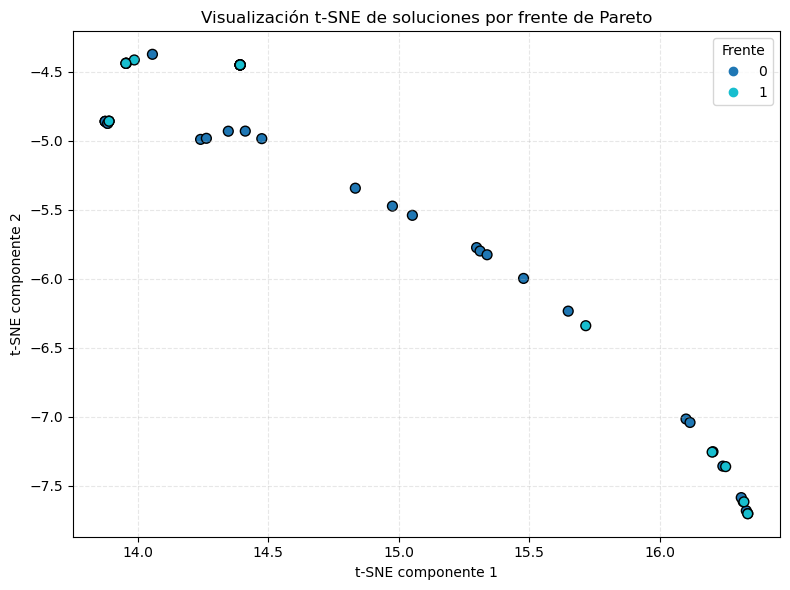

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que ya tienes: all_fronts = pareto_rank_all(solutions)

# Preparar datos
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)  # índice de frente

points = np.array(points)
labels = np.array(labels)

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedding = tsne.fit_transform(points)

# Graficar
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=labels, cmap="tab10", s=50, edgecolors='k')

plt.title("Visualización t-SNE de soluciones por frente de Pareto")
plt.xlabel("t-SNE componente 1")
plt.ylabel("t-SNE componente 2")
plt.grid(True, linestyle="--", alpha=0.3)
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper right")
plt.tight_layout()
plt.show()


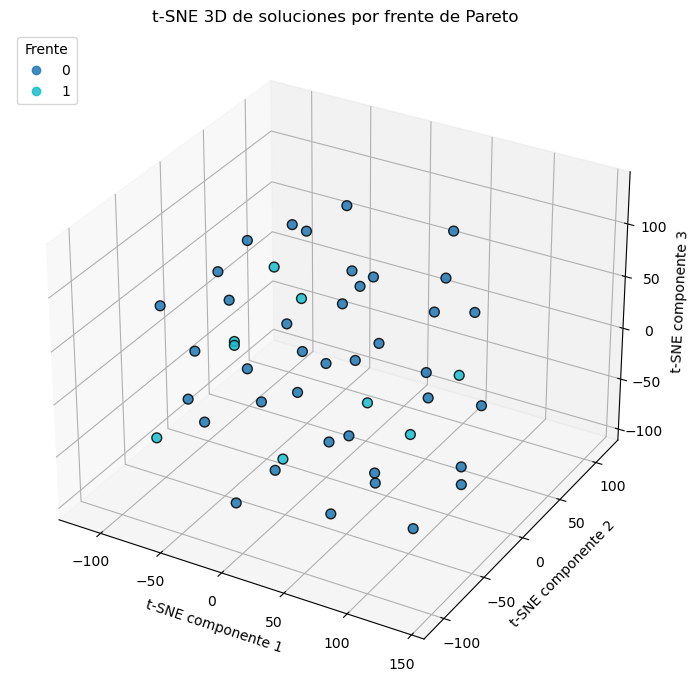

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para proyecciones 3D
import numpy as np

# Preparar puntos y etiquetas
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)

points = np.array(points)
labels = np.array(labels)

# Aplicar t-SNE en 3D
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
embedding = tsne.fit_transform(points)

# Crear gráfico 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2],
                     c=labels, cmap="tab10", s=50, edgecolors='k', alpha=0.85)

ax.set_title("t-SNE 3D de soluciones por frente de Pareto")
ax.set_xlabel("t-SNE componente 1")
ax.set_ylabel("t-SNE componente 2")
ax.set_zlabel("t-SNE componente 3")
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper left")
plt.tight_layout()
plt.show()


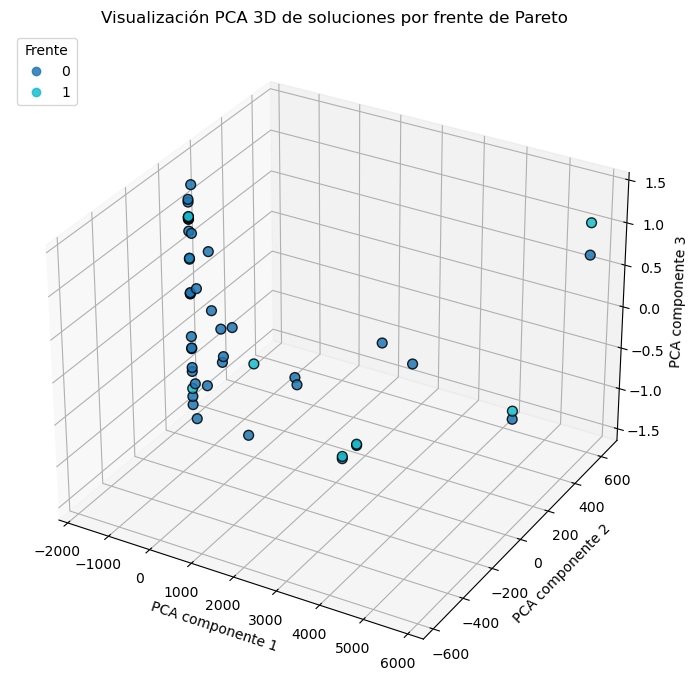

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Preparar puntos y etiquetas
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)

points = np.array(points)
labels = np.array(labels)

# Aplicar PCA en 3 componentes
pca = PCA(n_components=3)
embedding = pca.fit_transform(points)

# Graficar en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2],
                     c=labels, cmap="tab10", s=50, edgecolors='k', alpha=0.85)

ax.set_title("Visualización PCA 3D de soluciones por frente de Pareto")
ax.set_xlabel("PCA componente 1")
ax.set_ylabel("PCA componente 2")
ax.set_zlabel("PCA componente 3")
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper left")
plt.tight_layout()
plt.show()


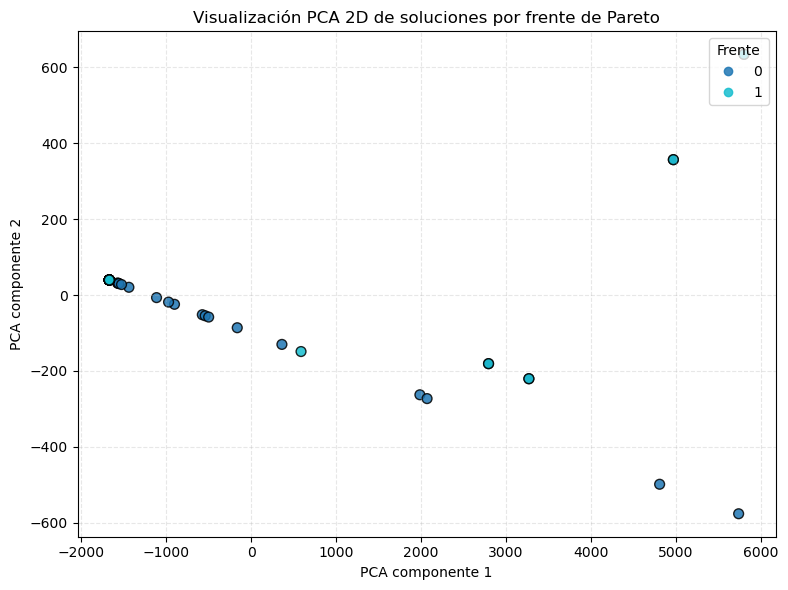

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que ya tienes: all_fronts = pareto_rank_all(solutions)

# Preparamos los datos
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)

points = np.array(points)
labels = np.array(labels)

# PCA en 2 componentes
pca = PCA(n_components=2)
embedding = pca.fit_transform(points)

# Graficar
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=labels, cmap="tab10", s=50, edgecolors='k', alpha=0.85)

plt.title("Visualización PCA 2D de soluciones por frente de Pareto")
plt.xlabel("PCA componente 1")
plt.ylabel("PCA componente 2")
plt.grid(True, linestyle="--", alpha=0.3)
legend = plt.legend(*scatter.legend_elements(), title="Frente", loc="upper right")
plt.tight_layout()
plt.show()


In [38]:
to_save = pd.DataFrame(solutions)

In [39]:
to_save.to_csv("datos_proj_2.csv")

In [170]:
# 4) Extraer Pareto y ordenar por crowding distance
pareto = pareto_front(solutions)
print("Solucion pareto", len(pareto))
print(pareto)

Solucion pareto 19
[{'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 1, 'x9': 5.7033448376090305, 'x11': 2.154744528081951, 'x4': 7175, 'x5': 69370, 'x6': 1, 'x7': 0.1361465681320511, 'x10': 3.0157170731707317, 'x12': 2.517208709099976, 'x13': 179.72231512181057}, 'f': array([3.43000000e+02, 2.69537014e-03, 8.63853432e-01, 3.62464181e-01,
       2.68762776e+00, 1.79722315e+02]), 'g': array([ -3416., -61853.]), 'graph': {'x4': 7175, 'x5': 69370, 'x6': 1, 'x7': 0.1361465681320511, 'x10': 3.0157170731707317, 'x12': 2.517208709099976, 'x13': 179.72231512181057}, 'filename': 'amz_bot_jaccard_NC_a2.graphml'}, {'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 1, 'x9': 5.7033448376090305, 'x11': 2.154744528081951, 'x4': 6462, 'x5': 21926, 'x6': 6, 'x7': 0.10504230798550232, 'x10': 5.159777823828991, 'x12': 3.2603758969210483, 'x13': 28994.42433640427}, 'f': array([1.05600000e+03, 1.05032260e-03, 8.94957692e-01, 1.10563137e+00,
       5.43567014e-01, 2.89944243e+04]), 'g': array([ 

In [171]:

cd = crowding_distance(pareto)
pareto_sorted = [s for _, s in sorted(zip(-cd, pareto), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))
print(pareto_sorted)

Crowding 19
[{'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 1, 'x9': 5.7033448376090305, 'x11': 2.154744528081951, 'x4': 6250, 'x5': 18404, 'x6': 1, 'x7': 0.00575180029970052, 'x10': 2.9165072, 'x12': 2.4015170446354484, 'x13': 16.299934796783308}, 'f': array([1.26800000e+03, 9.42435590e-04, 9.94248200e-01, 2.46772517e-01,
       2.78683764e+00, 1.62999348e+01]), 'g': array([ -2491., -10887.]), 'graph': {'x4': 6250, 'x5': 18404, 'x6': 1, 'x7': 0.00575180029970052, 'x10': 2.9165072, 'x12': 2.4015170446354484, 'x13': 16.299934796783308}, 'filename': 'amz_bot_vector_DF_a2.graphml'}, {'metrics': {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 1, 'x9': 5.7033448376090305, 'x11': 2.154744528081951, 'x4': 5674, 'x5': 16455, 'x6': 33, 'x7': 0.31225387133177557, 'x10': 5.924444024563061, 'x12': 3.4796363353330984, 'x13': 342.07359465208145}, 'f': array([1.84400000e+03, 1.02241160e-03, 6.87746129e-01, 1.32489181e+00,
       2.21099187e-01, 3.42073595e+02]), 'g': array([-1915., -8938.]), 'gr

In [172]:
# 5) Salida: lista de grafos óptimos (proyecciones)
optimal_graphs = [s["graph"] for s in pareto_sorted]
print("Crowding", len(cd))


Crowding 19


In [173]:
# Ejemplo: imprimir nombres de archivo en orden óptimo
print("Grafos óptimos ordenados por diversidad (crowding distance):")
for i, sol in enumerate(pareto_sorted, 1):
    print(f"{i:02d}. {sol['filename']} — f = {sol['f']}")

Grafos óptimos ordenados por diversidad (crowding distance):
01. amz_bot_vector_DF_a2.graphml — f = [1.26800000e+03 9.42435590e-04 9.94248200e-01 2.46772517e-01
 2.78683764e+00 1.62999348e+01]
02. amz_bot_jaccard_DF_a2.graphml — f = [1.84400000e+03 1.02241160e-03 6.87746129e-01 1.32489181e+00
 2.21099187e-01 3.42073595e+02]
03. amz_bot_master_DF_a2.graphml — f = [6.54000000e+02 1.18592248e-03 8.87258531e-01 1.14946176e+00
 9.26169432e-01 3.13080209e+04]
04. amz_bot_simple_NC_a05.graphml — f = [3.35000000e+02 2.40290891e-03 8.16858377e-01 5.83206192e-01
 2.09681275e+00 1.22627902e+00]
05. amz_bot_vector_DF_a1.graphml — f = [2.20200000e+03 7.97960257e-04 9.99860693e-01 6.12062285e-01
 2.44721241e+00 1.89540495e+01]
06. amz_bot_master_NC_a2.graphml — f = [3.35000000e+02 2.72585031e-03 8.84828845e-01 3.94666997e-01
 2.61079855e+00 2.06343201e+04]
07. amz_bot_jaccard_DF_a15.graphml — f = [2.95600000e+03 9.74754896e-04 6.98249311e-01 1.11858104e+00
 1.01892606e+00 3.37657825e+02]
08. amz_bot

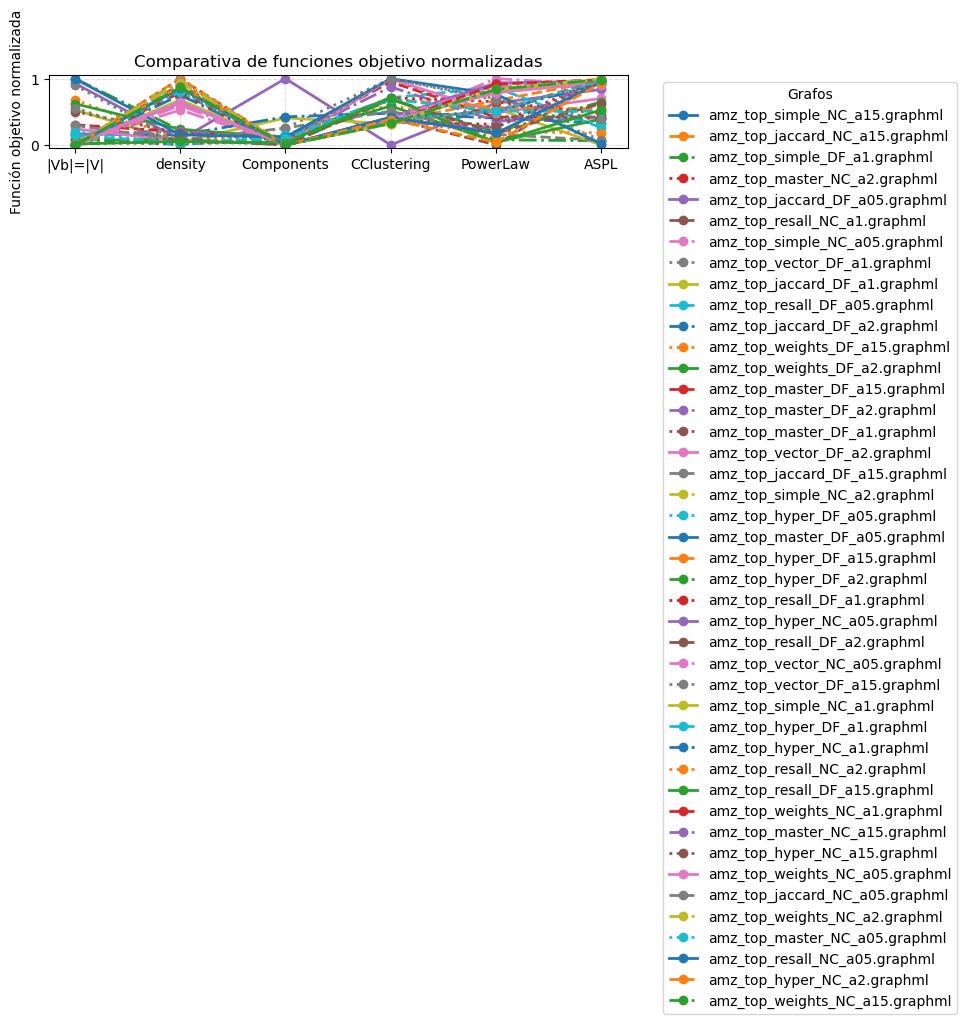

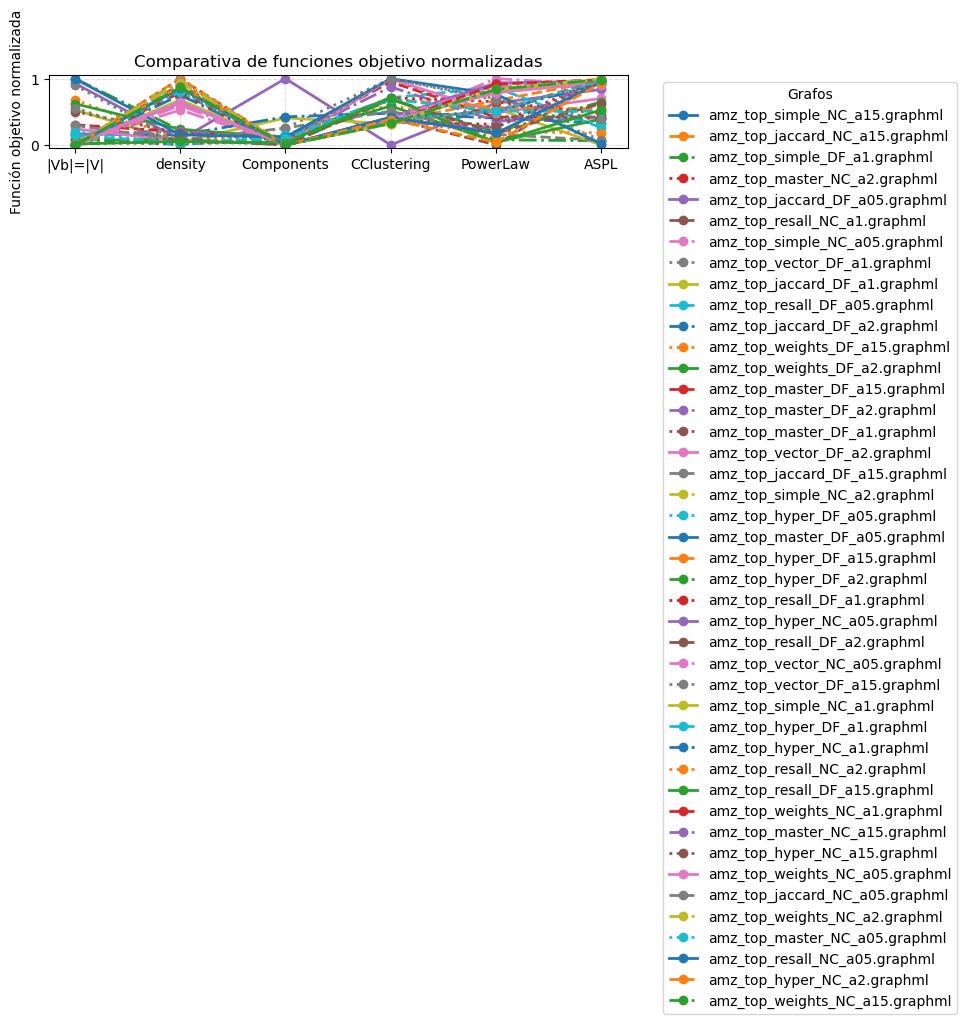

In [14]:
# Número máximo de grafos a graficar
N = len(pareto_sorted)
#labels = [f"f{i+1}" for i in range(6)]  # nombres de funciones f1..f6
labels = ["|Vb|=|V|", "density", "Components", "CClustering", "PowerLaw", "ASPL"]

# Extraer vectores f y nombres de archivo
F = np.array([s["f"] for s in pareto_sorted[:N]])
names = [s["filename"] for s in pareto_sorted[:N]]

# Normalizar funciones objetivo columna por columna# Número máximo de grafos a graficar
N = len(pareto_sorted)
#labels = [f"f{i+1}" for i in range(6)]  # nombres de funciones f1..f6
labels = ["|Vb|=|V|", "density", "Components", "CClustering", "PowerLaw", "ASPL"]

# Extraer vectores f y nombres de archivo
F = np.array([s["f"] for s in pareto_sorted[:N]])
names = [s["filename"] for s in pareto_sorted[:N]]

# Normalizar funciones objetivo columna por columna
F_norm = (F - F.min(axis=0)) / (F.max(axis=0) - F.min(axis=0) + 1e-8)

# Preparar figura
plt.figure(figsize=(10, 6))

# Colores y estilos variados
colors = plt.cm.tab10.colors
linestyles = ['-', '--', '-.', ':'] * 3

for i in range(N):
    plt.plot(
        labels,
        F_norm[i],
        label=names[i],
        color=colors[i % len(colors)],
        linestyle=linestyles[i % len(linestyles)],
        linewidth=2,
        marker='o'
    )

plt.ylabel("Función objetivo normalizada")
plt.title("Comparativa de funciones objetivo normalizadas")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Grafos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("test.png")
plt.show()

F_norm = (F - F.min(axis=0)) / (F.max(axis=0) - F.min(axis=0) + 1e-8)

# Preparar figura
plt.figure(figsize=(10, 6))

# Colores y estilos variados
colors = plt.cm.tab10.colors
linestyles = ['-', '--', '-.', ':'] * 3

for i in range(N):
    plt.plot(
        labels,
        F_norm[i],
        label=names[i],
        color=colors[i % len(colors)],
        linestyle=linestyles[i % len(linestyles)],
        linewidth=2,
        marker='o'
    )

plt.ylabel("Función objetivo normalizada")
plt.title("Comparativa de funciones objetivo normalizadas")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Grafos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("test.png")
plt.show()


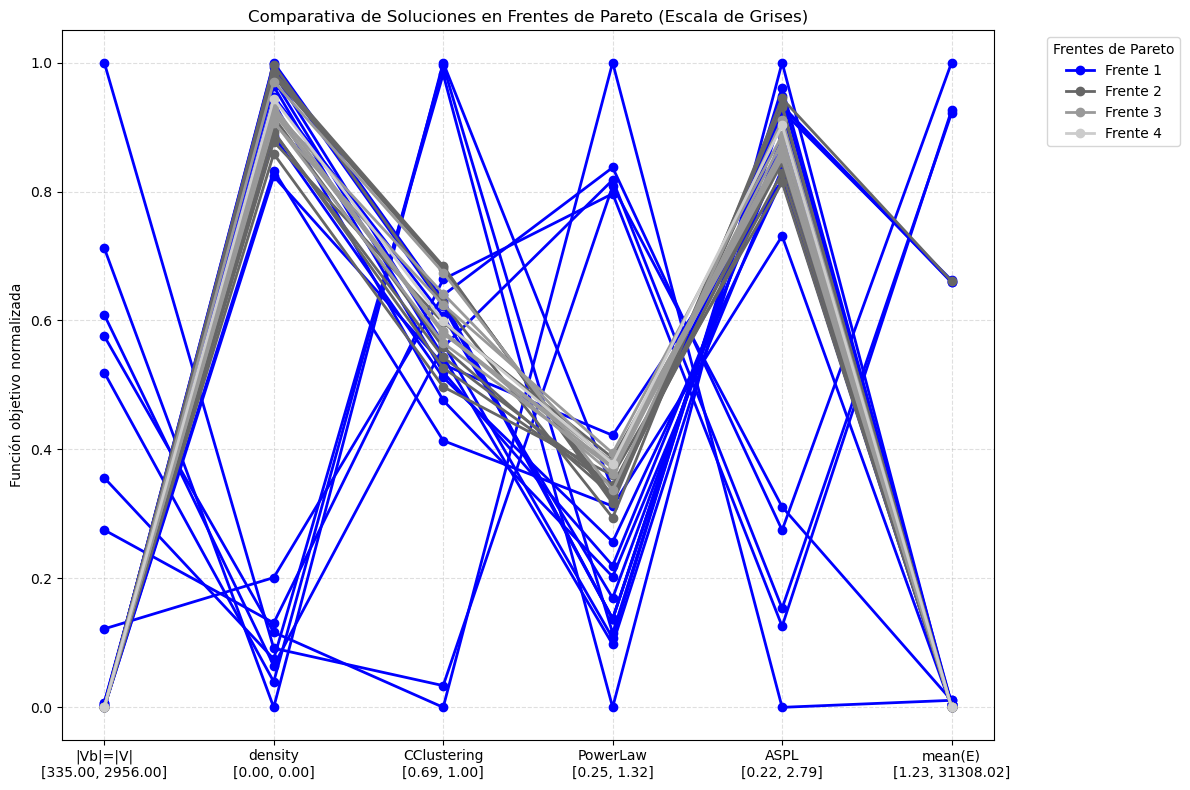

In [174]:
# --- Fin de la simulación de datos ---

labels = ["|Vb|=|V|", "density", "CClustering", "PowerLaw", "ASPL", "mean(E)"]

# 1. Aplanar la lista de frentes para normalizar todos los datos juntos
todas_las_soluciones = [sol for front in all_fronts for sol in front]
F_all = np.array([sol["f"] for sol in todas_las_soluciones])

# 2. Calcular los valores mínimo y máximo de cada función objetivo
min_vals = F_all.min(axis=0)
max_vals = F_all.max(axis=0)

# 3. Normalizar todos los valores
F_norm_all = (F_all - min_vals) / (max_vals - min_vals + 1e-8)

# 4. Preparar la figura para la gráfica
plt.figure(figsize=(12, 8))

# Generar una escala de grises
num_frentes = len(all_fronts)
# Usar `np.linspace` para generar valores de gris desde un tono oscuro a uno claro.
# Por ejemplo, desde un gris 0.2 (oscuro) hasta 0.8 (claro).
gray_scale = np.linspace(0.2, 0.8, num_frentes)

# 5. Recorrer los frentes y las soluciones para graficar
idx_solucion = 0
for i, front in enumerate(all_fronts):
    rank = i + 1
    # Asignar el color de la escala de grises al frente actual
    if i == 0:
        color = "blue"
    else:
        color = str(gray_scale[i])
    
    for j, sol in enumerate(front):
        F_norm_solucion = F_norm_all[idx_solucion]
        
        # Etiquetar solo el primer grafo de cada frente para la leyenda
        if j == 0:
            label = f"Frente {rank}"
        else:
            label = None

        plt.plot(
            labels,
            F_norm_solucion,
            color=color,
            linestyle='-',
            linewidth=2,
            marker='o',
            label=label
        )
        
        idx_solucion += 1

# 6. Actualizar las etiquetas del eje X con los rangos de valores reales
new_labels = [f"{lbl}\n[{min_v:.2f}, {max_v:.2f}]" for lbl, min_v, max_v in zip(labels, min_vals, max_vals)]
plt.xticks(range(len(new_labels)), new_labels, rotation=0)

# 7. Configurar y guardar la gráfica
plt.ylabel("Función objetivo normalizada")
plt.title("Comparativa de Soluciones en Frentes de Pareto (Escala de Grises)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Frentes de Pareto", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("frentes_de_pareto_grises.png")
plt.show()


In [177]:
len(solutions)

36

Matriz de correlación:
          f1        f2        f3        f4        f5        f6
f1  1.000000  0.450555 -0.241336 -0.491281 -0.488868 -0.183108
f2  0.450555  1.000000 -0.477271 -0.484593  0.172131 -0.169282
f3 -0.241336 -0.477271  1.000000 -0.065459  0.211854  0.063555
f4 -0.491281 -0.484593 -0.065459  1.000000 -0.272194  0.423147
f5 -0.488868  0.172131  0.211854 -0.272194  1.000000 -0.237044
f6 -0.183108 -0.169282  0.063555  0.423147 -0.237044  1.000000


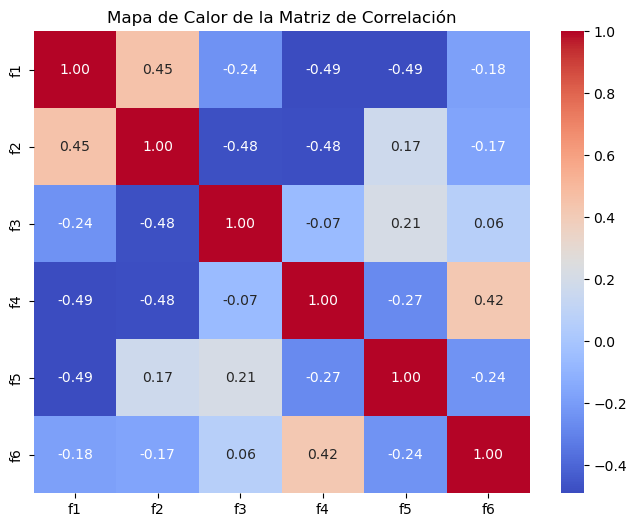

In [132]:
# Calculamos la matriz de correlación
correlation_matrix = final_DF[final_DF.columns[:-1]].corr()

print("Matriz de correlación:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Usamos la matriz de correlación que calculamos antes
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

Matriz de correlación:
          f1        f2        f3        f4        f5        f6
f1  1.000000 -0.574137  0.533384 -0.184137 -0.696339 -0.188015
f2 -0.574137  1.000000 -0.693040  0.216524  0.864077 -0.318614
f3  0.533384 -0.693040  1.000000 -0.183193 -0.656411  0.160740
f4 -0.184137  0.216524 -0.183193  1.000000  0.300152 -0.118366
f5 -0.696339  0.864077 -0.656411  0.300152  1.000000 -0.172860
f6 -0.188015 -0.318614  0.160740 -0.118366 -0.172860  1.000000


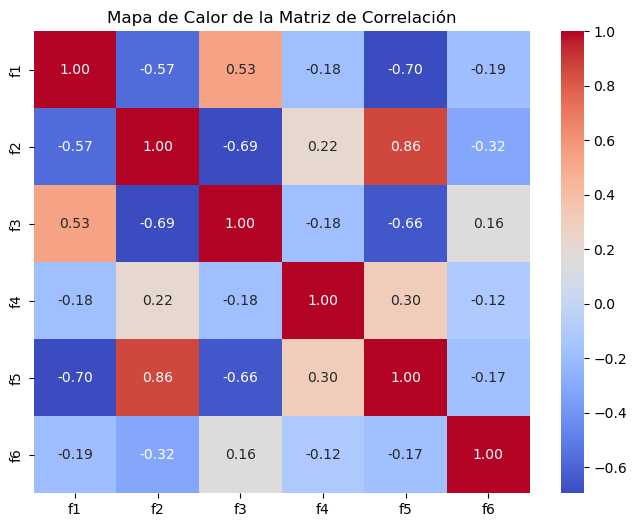

In [122]:
# Calculamos la matriz de correlación
correlation_matrix = final_DF[final_DF.columns[:-1]].corr()

print("Matriz de correlación:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Usamos la matriz de correlación que calculamos antes
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

In [62]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np

# Creamos un grafo de ejemplo con pesos
g = ig.Graph.GRG(1000, 0.1)
# Asignamos pesos aleatorios a las aristas (entre 1 y 10)
g.es["weight"] = np.random.power(3, g.ecount())

# Extraer todos los pesos en una lista
pesos = gu.es["weight"]

# Opcional: imprimir los primeros 10 pesos para verificar
print("Primeros 10 pesos de aristas:", pesos[:10])

Primeros 10 pesos de aristas: [222.0, 6.0, 250.0, 334.0, 429.0, 211.0, 7.0, 26.0, 14.0, 6.0]


COnjunto de restricciones:
    Si el coeficiente de clustering no está en 1/n << CC <1
    Si el número de aristas es menor que la cuerda. n-1
    Si se eliminan más de la mitad de los nodos n/2